<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/mbp_aki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of AKI risk depending on BP during surgery
In this example, we will calculate the risk of acute kidney injury (AKI) depending on blood pressure during surgery, using the open dataset <code>vitaldb</code>.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries and datasets

In [1]:
import pandas as pd
import numpy as np

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # Load clinical data
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # Load track list
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # Load lab result
df_cases

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,5583,0,15248,-260,15640.0,2140,14140,-215340,648660,...,0,150,0.0,0,90,0,20,0,0,0
6384,6385,2278,0,20643,-544,20996.0,2396,19496,-225600,1675200,...,0,100,0.0,0,100,0,25,30,0,300
6385,6386,4045,0,19451,-667,19133.0,3533,18233,-200460,836340,...,0,70,0.0,0,130,0,10,0,0,0
6386,6387,5230,0,12025,-550,12830.0,1730,11030,-227760,377040,...,0,120,0.0,0,50,0,0,0,0,0


## Case Selection
- Use only 100 emergency surgical patients.

In [2]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['department'] == 'General surgery']['caseid']) &
    set(df_cases[df_cases['emop'] == 1]['caseid'])
)
caseids = caseids[:100]
print('Total {} cases found'.format(len(caseids)))

Total 100 cases found


## Load and calculate data for each case
- First of all, calculate the preoperative and postoperative creatinine concentration for each case, and then calculate the possibility that AKI occurs.

- Secondly, obtain the ART_MBP data from vitaldb datasets. Then, calculate the proportion of surgeries that have a measured value lower than the threshold between 40-80 mmHg in all surgeries.

In [3]:
# Set blood pressure threshold
mbp_thresholds = np.arange(40, 80)

# Save the final result
df = pd.DataFrame()
for caseid in caseids:
    print('loading {}...'.format(caseid), flush=True, end='')

    # Column ['anend'] : anesthesia end time
    aneend = df_cases[(df_cases['caseid'] == caseid)]['aneend'].values[0]

    # Last creatinine concentration before surgery
    preop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] < 0) & (df_labs['name'] == 'cr')].sort_values(by=['dt'], axis=0, ascending=False)['result'].values.flatten()
    if len(preop_cr) == 0:
        print('no preop cr')
        continue
    preop_cr = preop_cr[0]

    # Maximum creatinine concentration within 48 hours after surgery
    postop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] > aneend) &
        (df_labs['dt'] < aneend + 48 * 3600) & (df_labs['name'] == 'cr')]['result'].max(skipna=True)
    if not postop_cr or np.isnan(postop_cr):
        print('no postop cr')
        continue

    # KDIGO stage I
    aki = postop_cr > preop_cr * 1.5

    # Blood pressure during surgery
    tid_mbp = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
    print(tid_mbp)
    mbps = pd.read_csv('https://api.vitaldb.net/' + tid_mbp).values[:,1]
    mbps = mbps[~np.isnan(mbps)]
    mbps = mbps[(mbps > 20) & (mbps < 150)]
    if len(mbps) < 10:
        print('no mbp')
        continue
    
    # Calculate the percentage that stays for the time as increasing the blood pressure by 1 unit.
    row = {'aki':aki}
    for mbp_threshold in mbp_thresholds:
        print(mbp_threshold)
        row['under{}'.format(mbp_threshold)] = np.nanmean(mbps < mbp_threshold) * 100
    
    # Append the result into row
    df = df.append(row, ignore_index=True)

    print('{} -> {}, {}'.format(preop_cr, postop_cr, 'AKI' if aki else 'no AKI'))

print('{} AKI {:.1f}%'.format(df['aki'].sum(), df['aki'].mean() * 100))

loading 6144...930d5cff9f3d9d5d74c2e31aa8996a3fd9941ec8
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.5 -> 0.57, no AKI
loading 2063...

C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


6dfe63155e3c40dd9fd1907c1128fd294ca94384
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.71 -> 1.26, AKI
loading 4112...no postop cr
loading 4115...

C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


1be1515c38aae0c89dbedad0a40871ac9b88bb00
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.07 -> 0.9, no AKI
loading 4116...a1924e7a67a7b45e989b9f2387578135e4af69d8


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.63 -> 0.72, no AKI
loading 24...no preop cr
loading 29...faed763dc835eddbe4b200d74125b05c3fe58634


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.78 -> 0.74, no AKI
loading 32...no postop cr
loading 4135...0c20592718c82e4c9f878772e227fc2791cec7fe


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
2.65 -> 2.3, no AKI
loading 4144...0ec8b167bd6e3e441f4d02d1a15450116ea5b586


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
17.74 -> 15.82, no AKI
loading 6196...94eb13572c9d38d528ce7cf31c316d81de8fea90


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.82 -> 1.0, no AKI
loading 4150...no postop cr
loading 4155...09769cf669cbfa72ac42b18c88dfba758c05b2a1


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.15 -> 2.19, AKI
loading 60...873e93a6e9e61be2a6fc190fd052dd54cf075b4a


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
9.36 -> 7.95, no AKI
loading 2117...52efd5f6a7145863b3ef7185e8a4e97802e73dc5


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.84 -> 0.89, no AKI
loading 4168...6af8a04c7b68308136646d9195aab955bde9235d


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.73 -> 0.62, no AKI
loading 2130...62043cf790ccd3b88d3c1db6f048c90726b1f0e9


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
14.8 -> 9.02, no AKI
loading 83...7b9515a49ebb477376f5a09944f78cadebfc2a1f


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
8.13 -> 7.36, no AKI
loading 87...6455e0c3973d42f3c9aba25026087f98eac6efda


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
2.72 -> 2.35, no AKI
loading 2138...no postop cr
loading 2147...20b12dd8fd35b85663fb8e7809da0c864d390509


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.44 -> 0.52, no AKI
loading 4195...6baf50774b664899ea4217bd417735893f78d049


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.89 -> 0.96, no AKI
loading 2157...782daaf00712a5dfd45ec572f3fdff7840427a2d


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.78 -> 0.74, no AKI
loading 4213...d024aa93679ea5393a8a47a9a139ab95ffad8455


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.88 -> 0.66, no AKI
loading 6262...no preop cr
loading 124...601db06030c45ec10fdeb91bbfeee18cefcd3c2a


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.63 -> 0.63, no AKI
loading 2174...c12ea814f458b7319e866b0313c95ebaa57aab7e


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
5.42 -> 4.63, no AKI
loading 4225...no postop cr
loading 6273...no preop cr
loading 138...f06f0945135b083ed88670a7c9a0c6f99a5b4866


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.72 -> 0.65, no AKI
loading 6283...34ae1bf3717b1037e97aa460d20d0c65c6b88929
40
41


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.86 -> 0.77, no AKI
loading 143...no preop cr
loading 146...8b366f5aae5a35b89273a7dc907ba067a67021d4


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.62 -> 1.8, AKI
loading 6290...5568700746040df18bd34679d13788d119ae27e2


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.54 -> 1.79, no AKI
loading 6292...42281b82428890db95ae9ebddd97abeff3595611
40
41
42
43
44
45
46
47
48
49
50
51


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
9.47 -> 7.41, no AKI
loading 6293...4f611c0d122589231de0e0f000df563591f61805


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.94 -> 1.09, no AKI
loading 4247...af9f48dd7d067269d900c9b5fbc4a946dd28ddee


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.95 -> 1.05, no AKI
loading 6297...c4a77c9980aca06437bb66f42320939709d67e56


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.79 -> 0.63, no AKI
loading 4251...a26b6e7ae16f8cfc2d6f309387beef51f3ff9749
40
41
42
43


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.98 -> 0.82, no AKI
loading 4254...baff35a09a863b7912ab6934452818d2cd70825a


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.83 -> 1.22, no AKI
loading 2214...no preop cr
loading 6315...no postop cr
loading 2223...b58b718cddaa8b3cf77efaa51cbbbacd1a021f28


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.52 -> 1.15, no AKI
loading 177...3c744aef041b6cc517fb6ea9ff3a01ffdcab5ce6


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
15.94 -> 14.2, no AKI
loading 185...902d918f843de4f26f4b791fa0a19e00364102ad


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.45 -> 0.4, no AKI
loading 2239...no preop cr
loading 6335...e282865662036bd995c7c35eeaa3fedb099abe29


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.95 -> 0.98, no AKI
loading 2241...e2605bcf014c078213b606bb9a1275ed3059b0a3


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.57 -> 0.54, no AKI
loading 4290...eedb4323ce9e2b7372fcbcb3188c015b236b107f


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.89 -> 0.79, no AKI
loading 4302...8ed790c942cdfeb910cf93027e6c8654e3d394a1


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.66 -> 0.74, no AKI
loading 2255...02bee10e77a75c289f7febdf713d03aa2f87af14


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.88 -> 0.72, no AKI
loading 4308...no preop cr
loading 2265...f6c94c849eb6c15e9f096a9ef06ea9a4ce0f9944


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.84 -> 0.66, no AKI
loading 2272...e76f647102acf4a6800134bd43ddf505a02f934b


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.2 -> 1.79, no AKI
loading 6372...5df7e2e61d8e1112baa3dc848fabbabe5f6420ea


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.01 -> 0.76, no AKI
loading 232...no postop cr
loading 4328...368f7acf45c2dee6887cf26af5d83ea0f1b28796


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.33 -> 1.78, no AKI
loading 239...34141aab3e38eb1abc19ec306e5e73a9bac79578


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.79 -> 1.45, AKI
loading 6383...b77c7d47f3b58eb22899652bb496b99d43292f6e


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
6.7 -> 6.14, no AKI
loading 242...no postop cr
loading 243...no postop cr
loading 250...

C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


6055927b408971f879be765927dd8c31d055aae9
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.79 -> 0.73, no AKI
loading 264...no postop cr
loading 268...238dbfdaebfefbe624fb402ee1ca6b859f4b7e7d


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.86 -> 0.86, no AKI
loading 2327...16d09586abba561165c60a804b57407a91346fa5
40
41


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.61 -> 1.0, AKI
loading 2331...225114b8e6e7c1118c7e9aaa00afaf6b1c8f45c4


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.37 -> 0.99, no AKI
loading 284...0b6b350e03731579d1446010b5d7e2a8e1f4d381


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
6.82 -> 5.98, no AKI
loading 2337...d7af4b51fa9e0237048b7072900d024be8f55f73


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
8.78 -> 8.65, no AKI
loading 2345...ecdffeaaa9b62b07018aab38249fc17340286dc6
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63

C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)



64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.28 -> 1.15, no AKI
loading 4408...cdc8edf0bf26de57f891287c8054623ce853bd1f


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.58 -> 0.63, no AKI
loading 2372...2a7610793b993caff8c7be851bd118581a25764f


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.95 -> 1.03, no AKI
loading 2373...f9ad86c0feffee5554c80ee1b4f4235c402b46bf


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.51 -> 0.55, no AKI
loading 4433...4ec6c50a150c27512339c1f90c0242baf41a42a1


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.0 -> 1.07, no AKI
loading 349...24fd093c8098cc46e7d2bc3ac50e23b35163d0b7


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.07 -> 1.61, AKI
loading 4449...a3ef7d7ba4e478bbf5905fc884fe9cfc1a6cadab


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.21 -> 0.3, no AKI
loading 355...f0f5614631d12ecdd22f24381edb1a78e12e838b


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
2.24 -> 1.45, no AKI
loading 4465...93406241957e33289524df52982adb6352d47549


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
9.27 -> 7.3, no AKI
loading 370...no preop cr
loading 381...no preop cr
loading 2432...no preop cr
loading 387...

C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


3f4ce10faedf5b86a299ecce62b627cd578b03ee
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
2.05 -> 1.49, no AKI
loading 4489...993469efc793d666d28d4ce4d6b818ffa92da955


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.66 -> 0.76, no AKI
loading 2447...8c1466766d27bc2e9f523b196ecb82dc479f488e


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.02 -> 1.12, no AKI
loading 4496...42cfa2266474c3bea4e853844562cad6eabd1126


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.57 -> 0.53, no AKI
loading 406...af017868551a03ee09b1461e8dfae5b5b9ea411a


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
8.96 -> 8.5, no AKI
loading 4509...3553025555cc2e92b434ee46353e531d66bf32d8


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
10.76 -> 6.83, no AKI
loading 415...b7497438480a2e76eb358c1c9d8187ce7bcf5f45


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.51 -> 0.45, no AKI
loading 427...46fce843a9b7d494c5d47ca8940ae1fd512070f6


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.91 -> 0.8, no AKI
loading 431...4d8000fae1bfa638030453e311c6f57ecdf1633a
40
41
42


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
15.12 -> 13.18, no AKI
loading 2480...7bcb91c5f34770d4ed16e0eccdbc44c1262e76ce


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.46 -> 0.55, no AKI
loading 441...no preop cr
loading 4538...no preop cr
loading 2494...4a07a4256edaaf46c7536debfc190890a0648cfe


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.73 -> 0.63, no AKI
loading 2501...3a8a8b02902a3aed79c4bf1815fda45bdd5e563b


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.03 -> 1.05, no AKI
loading 2504...5353e8630ed22d343abaecfc8724b167be7328ab


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.72 -> 0.61, no AKI
loading 4556...4f1a6412a5cc7faa20421145f4afb271c1661081


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.9 -> 0.9, no AKI
loading 464...no postop cr
loading 2516...9a4a94ce9a23d435aa8139d274e917d35cad8881


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1.23 -> 1.86, AKI
loading 476...no preop cr
loading 477...772466659098bfb6b533ae89cdeb8864d83e277d


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0.58 -> 0.43, no AKI
7 AKI 9.2%


C:\Users\admin\AppData\Local\Temp\ipykernel_16236\2483221045.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


## Calculate the odds ratio for AKI prediction depending on blood pressure threshold

- Let's calculate the odds ratio regarding how much each BP class increases the risk of AKI, using the above-measured values.

In [4]:
import statsmodels.api as sm

# Get odd ration using univariate logistic regression
df['intercept'] = 1
df['aki'] = df['aki'].astype(bool)
odd_ratios = []
for mbp_threshold in mbp_thresholds:
    c = 'under{}'.format(mbp_threshold)
    model = sm.Logit(df['aki'], df[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.284250
         Iterations 7
under40	b=0.303, exp(b)=1.354, pval=0.043
Optimization terminated successfully.
         Current function value: 0.280257
         Iterations 7
under41	b=0.295, exp(b)=1.343, pval=0.032
Optimization terminated successfully.
         Current function value: 0.277748
         Iterations 7
under42	b=0.276, exp(b)=1.318, pval=0.028
Optimization terminated successfully.
         Current function value: 0.277614
         Iterations 7
under43	b=0.251, exp(b)=1.286, pval=0.031
Optimization terminated successfully.
         Current function value: 0.275456
         Iterations 7
under44	b=0.236, exp(b)=1.267, pval=0.028
Optimization terminated successfully.
         Current function value: 0.269139
         Iterations 7
under45	b=0.227, exp(b)=1.255, pval=0.018
Optimization terminated successfully.
         Current function value: 0.264550
         Iterations 7
under46	b=0.201, exp(b)=1.222, pva

## Draw a graph
- We can find out that the odds ratio of AKI increases as the time that MBP stays below 60-65mmHg increases.


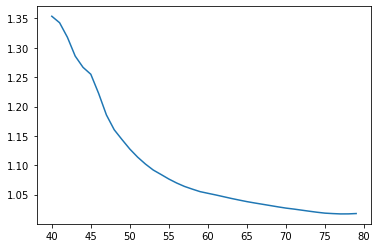

In [5]:
import matplotlib.pyplot as plt
plt.plot(mbp_thresholds, odd_ratios)
plt.show()